In [21]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
from main_2 import conditioning_signal, get_mixed_signal
from utils import signal_segmentation, find_segments_limits
from process_functions import preprocessing_audio
from heart_sound_segmentation.filter_and_sampling import downsampling_signal, upsampling_signal

In [75]:
def conditioning_heart_sound(signal_index, nmf_parameters, snr_expected,
                     nmf_method='masked_segments', print_metrics=False,
                     base_factor= 0.05, N_wind=100, plot_segmentation=False, 
                     plot_separation=False):
    def _adjust_lenghts(signal_1, signal_2):
        # Asegurando de que los largos de las señales sean los mismos
        len_max = max(len(signal_1), len(signal_2))
        
        if len(signal_1) != len_max:
            signal_1 = np.concatenate((signal_1, [0] * (len_max - len(signal_1))))
        elif len(signal_2) != len_max:
            signal_2 = np.concatenate((signal_2, [0] * (len_max - len(signal_2))))
            
        return signal_1, signal_2
    
    ######### Import de archivos de audio #########
    
    # A partir de este índice, obtener el nombre del sonido cardiaco
    for i in zip(heart_filenames, resp_filenames):
        if int(i[0].split(' ')[0]) == signal_index:
            heart_name = i[0]
            resp_name = i[1]
            break
    
    # Cargar archivo de sonido respiratorio
    resp_signal, resp_sr = sf.read(f'{db_resp}/{resp_name}')
    # Cargar archivo de sonido cardiaco
    heart_signal, heart_sr = sf.read(f'{db_heart}/{heart_name}') 
    
    # Acondicionando el sonido respiratorio y cardiaco
    resp_to = conditioning_signal(resp_signal, resp_sr, samplerate_des, 
                                  bandwidth=100)
    heart_to = conditioning_signal(heart_signal, heart_sr, samplerate_des, 
                                   bandwidth=100)
       
    # Realizando la mezcla, solo para cortar en caso de que sea necesario
    mixed_to, resp_to, heart_to = \
            get_mixed_signal(resp_to, heart_to, snr_expected=snr_expected, 
                             plot_signals=False, print_snr=True, 
                             normalize=False)
    
    
    ######### Posición de los sonidos cardiacos #########
    
    # Clasificando
    _, y_hat_to, (y_out2, _, _) = \
        signal_segmentation(heart_to, samplerate_des, model_name,
                            length_desired=len(mixed_to), 
                            lowpass_params=lowpass_params, 
                            plot_outputs=False)
    
    # Definiendo la lista de intervalos
    interval_list = find_segments_limits(y_out2, segments_return='Heart')
    
    if plot_segmentation:
        fig, ax = plt.subplots(2, 1, figsize=(9,5), sharex=True)
        mixed_to_plot = mixed_to / max(abs(mixed_to))
        audio_data_plot = 0.5 * mixed_to_plot / max(abs(mixed_to_plot))
        ax[0].plot(audio_data_plot - min(audio_data_plot), label=r'$s(n)$', 
                 color='silver', zorder=0)
        ax[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
        ax[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
        ax[0].plot(y_hat_to[0,:,2], label=r'$S_2$', color='blue', zorder=1)
        ax[0].legend(loc='lower right')
        ax[0].set_yticks([0, 0.5, 1])
        ax[0].set_ylabel(r'$P(y(n) = k | X)$')

        ax[1].plot(y_out2)

        plt.show()
        
    # Suprimir ruido en las bandas que no interesan. Se obtiene una representación
    # suavizada para el fade
    conv_sign = np.convolve(y_out2, np.hamming(N_wind), 'same')
    conv_sign = conv_sign / max(abs(conv_sign)) * (1 - base_factor) + base_factor
    
    # Redefiniendo
    heart_to = heart_to * conv_sign
    mixed_to = resp_to + heart_to
    
    # Interactivo
    fig, ax = plt.subplots(2, 2, figsize=(12, 9), sharex=False)
    ax[0][0].plot(y_out2, label='Posiciones sonidos cardiacos')
    ax[0][0].set_xlim([0, 11000])
    ax[0][0].set_ylabel('Posición de sonidos cardiacos')
    
    ax[0][1].plot(np.hamming(N_wind), color='red', label='Ventana Hamming')
    ax[0][1].set_ylabel('Ventana Hamming de suavizado')
    
    ax[1][0].plot(heart_to, label='Señal de entrada', zorder=0)
    ax[1][0].plot(conv_sign, label='Envolvente', zorder=2)
    ax[1][0].axhline(0.1, color='red', linestyle='dotted', zorder=1)
    ax[1][0].legend(loc='lower right')
    ax[1][0].set_xlim([0, 11000])
    ax[1][0].set_yticks([-1, -0.5, 0, 0.1, 0.5, 1])
    ax[1][0].set_yticklabels([-1, -0.5, 0, r'$\kappa$', 0.5, 1])
    ax[1][0].set_ylabel('Señal original')
    ax[1][0].set_xlabel('Muestras')
    
    ax[1][1].plot(heart_to * conv_sign, color='C2', label='Señal de salida')
    ax[1][1].set_xlim([0, 11000])
    ax[1][1].legend(loc='lower right')
    ax[1][1].set_yticks([-1, -0.5, 0, 0.5, 1])
    ax[1][1].set_ylabel('Señal procesada')
    ax[1][1].set_xlabel('Muestras')
    
    fig.align_ylabels(ax[:])
    plt.savefig('Images/Heart_sound_conditioning.pdf', transparent=True)
    plt.show()

# Plots acondicionamiento señal cardiaca

SNR obtained = 9.64327466553287e-16 dB
Downsampling de la señal de fs = 11025 Hz a fs = 1000 Hz.
Señal acondicionada a 1000 Hz.
1/1 [==============================] - ETA:  - 0s 2ms/step


<IPython.core.display.Javascript object>


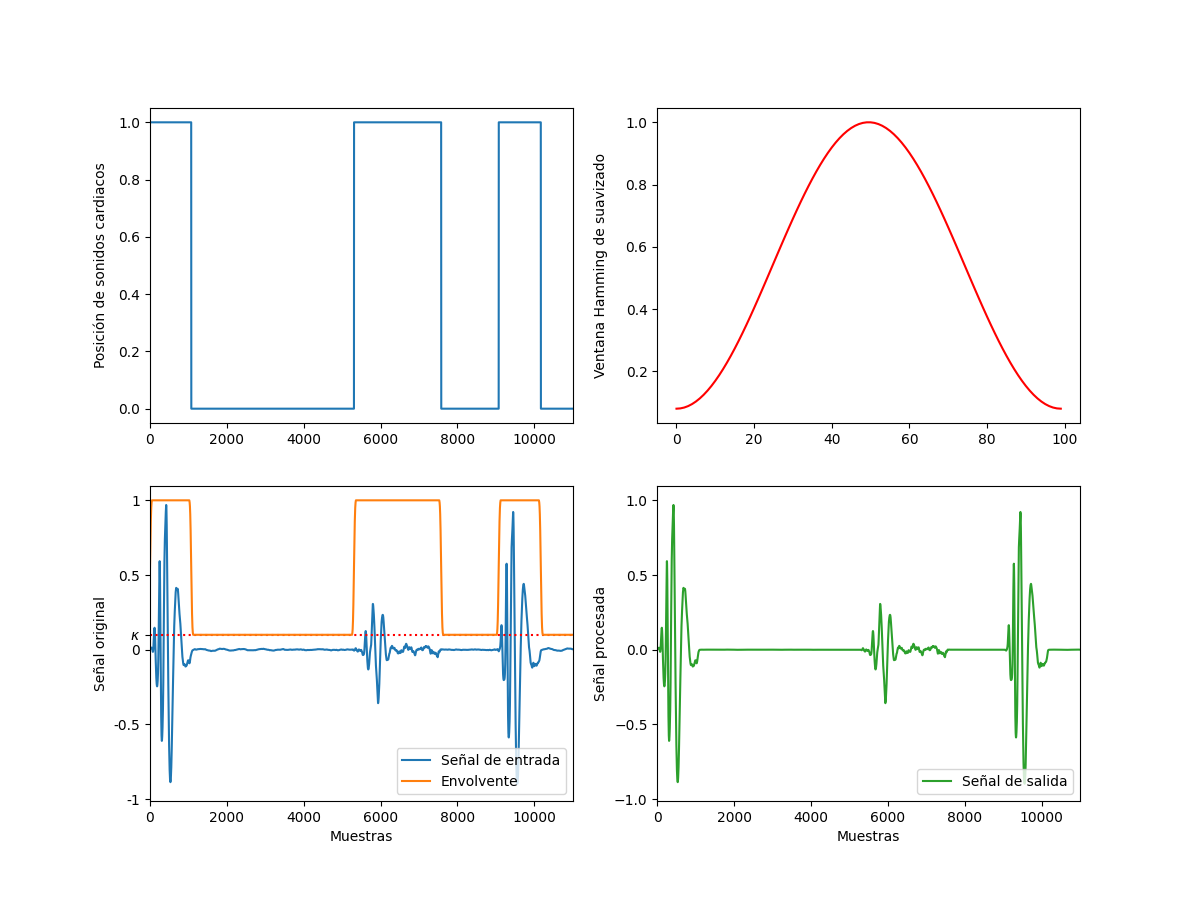

In [76]:
samplerate_des = 11025
model_name = 'definitive_segnet_based'
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}

# Definición de la dirección de la base de datos de sonidos resp
db_resp = '_beta_cardiorespiratory_database/Resp_Sounds'
# Definición de la dirección de la base de datos de sonidos cardiacos
db_heart = '_beta_cardiorespiratory_database/Heart_Sounds'

# Archivos .wav de la carpeta
resp_filenames = [i for i in os.listdir(db_resp) if i.endswith('.wav')]
heart_filenames = [i for i in os.listdir(db_heart) if i.endswith('.wav')]

nmf_parameters = {'n_components': 5, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': 768, 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 1, 'tol': 1e-4, 
                  'max_iter': 200, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'vote'}

signal_index = 11
%matplotlib notebook
a = conditioning_heart_sound(signal_index, nmf_parameters, snr_expected=0, 
                             nmf_method='to_all', plot_segmentation=False, 
                             plot_separation=True, base_factor=0.1, N_wind=100)